In [1]:
import re
import string
import pickle
import pandas as pd
import numpy as np
import matplotlib.dates as md
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
from nltk.stem import PorterStemmer

from bokeh.palettes import Category20, brewer
from bokeh.plotting import *
from bokeh.models import *
from bokeh.plotting import figure, show, output_file
from bokeh.layouts import gridplot, column

In [2]:
DATA_FOLDER = 'Data/'
TWEET_DATA = 'russian-troll-tweets/IRAhandle_tweets_'
APPROVAL_DATA = 'approval_polllist.csv'
APPROVAL_POLLLIST = 'approval_polllist.csv'
CAMPAIGN_POLLS = 'presidential_polls.csv'
plot_files='Plots/'
pickle_files='Pickles/'
csv_files='Csv/'

# Introduction

This notebook focuses on the analysis of Trump's approval rating and introduces a "key hashtags" dataframe useful to understanding the causes behind the tweet peaks.

# Data Loading

## Tweets data

In [3]:
def get_date_time(x):
    """
    From string to datatime.date()
    input: 
        x    : str
    output:
        date : datetime - Only month/day/year
        time : datetime - Only hour/minutes/
    """
    date_time = dt.datetime.strptime(x, '%m/%d/%Y %H:%M')
    #print(date_time)
    date = date_time.replace(minute=0, hour=0, second=0)
    #print(date)
    time = date_time.hour
    #type(time)
    
    return date


def cleaning_plot(df,dataset):
    """
    Cleans and selecting relevant tweets.
    input:
        df      - pd.DataFrame: Containing one of the IRA datasets
        dataset - int         : The IRA dataset ID
    output:
        df_tmp  - pd.DataFrame: Cleaned IRA dataset
    """
    RELEVANT_COL = ['author', 'publish_date', 'account_category', 'content', 'following', 'followers', 'retweet']
    
    #We will only select tweets in english. This represents 77% of the datasets.
    df_tmp = df[df.language == 'English'].drop(columns={'harvested_date', 'language'})
    df_tmp = df_tmp[RELEVANT_COL]

    #Keeping only right troll and left troll tweets. (57% datasets)
    df_tmp = df_tmp[(df_tmp.account_category == 'RightTroll') | (df_tmp.account_category == 'LeftTroll')  ]

    #date 
    df_tmp['publish_date'] = df_tmp.publish_date.apply(lambda x: get_date_time(x))
    df_tmp = df_tmp[df_tmp.publish_date > dt.datetime(2014,10,1,0,0,0)] #selecting after Oct 2014

    df_tmp['dataset'] = dataset #from which dataset it comes

    return df_tmp

Loading data from the tweets

In [4]:
tweet_data = pd.DataFrame()

# The dataset is composed of 9 sub_datasets
for dataset in range(1,9):
    df_tmp = cleaning_plot(pd.read_csv(DATA_FOLDER + TWEET_DATA + str(dataset) + '.csv'), dataset)
    tweet_data = tweet_data.append(df_tmp, ignore_index=True)

## Polls data

In [5]:
df = pd.read_csv(DATA_FOLDER + APPROVAL_DATA)
#Selecting only relevant columns for approval data
UNRELEVANT = ['president', 'modeldate', 'createddate', 'enddate', 'url',\
              'question_id', 'tracking', 'multiversions', 'timestamp']
approval_df = df.drop(columns=UNRELEVANT)

#keeping only good pollster
#GOOD_GRADES = ['A+', 'A', 'A-', 'B+']
#approval_df = approval_df[approval_df.grade.isin(GOOD_GRADES)]


#Datetime format
approval_df.startdate = approval_df.apply(lambda row: datetime.strptime(row['startdate'], "%m/%d/%Y"),\
                                            axis=1)
approval_df.sort_values(by=['startdate'], inplace=True)
approval_df.reset_index(drop=True, inplace=True)
approval_df.head()

,subgroup,startdate,pollster,grade,samplesize,population,weight,influence,approve,disapprove,adjusted_approve,adjusted_disapprove,poll_id
0,All polls,2017-01-20,Morning Consult,B-,1992.0,rv,0.946437,0.0,46.0,37.0,42.97840,39.17828,49249
1,Adults,2017-01-20,Ipsos,B+,1632.0,a,0.224456,0.0,42.1,45.2,41.68539,44.23673,49426
2,Voters,2017-01-20,Morning Consult,B-,1992.0,rv,0.946437,0.0,46.0,37.0,44.03498,38.65438,49249
3,Voters,2017-01-20,Ipsos,B+,509.0,lv,0.127926,0.0,45.2,44.3,44.95828,42.77118,49426
4,Voters,2017-01-20,Quinnipiac University,A-,1190.0,rv,1.644662,0.0,36.0,44.0,38.64014,42.18154,49260


In [6]:
#We looked for events corresponding to increased tweet density
events_date = ["2015-07-21", "2015-11-15", "2015-11-15", "2016-03-22", 
               "2016-09-16", "2016-09-26", "2016-09-27", "2016-10-04", 
               "2016-10-06", "2016-10-07", "2016-10-07", "2016-10-07",
               "2016-11-08", "2016-11-09", "2017-07-24", "2017-07-31", 
               "2017-08-03", "2017-08-08", "2017-08-11"]
events_list = ["Chattanooga shootings", "Democrate Debate", 
               "Jamar Clark was shot by Minneapolis Police Department - BlackLivesMatter", 
               "Brussels Bombings", "CNN releases poll of polls: Hillary ahead by 2 points", 
               "Presidential Debate", "Alfredo Olango Police shooting - Blacklivesmatter", 
               "VP debate","Istanbul bombings", "Grab her by the pussy", "Obama admin. says Russia hacked DNC", 
               "Wikileaks releases Clinton emails", "Election Day", "Trump Elected", "Imran Awan scandal", 
               "Charlie Baker, GOP Gov is reelected as Massachusset gov", 
               "Leaked telephone conversations between Donald Trump and foreign leaders are leaked. ", 
               "North Korea Crisis", "Charlottesville riot"]
events_cat = ["RightTroll", "RightTroll", "LeftTroll", 
              "RightTroll", "RightTroll", "RightTroll", 
              "LeftTroll", "RightTroll", "RightTroll", 
              "LeftTroll", "RightTroll","LeftTroll", 
              "Both", "RightTroll", "RightTroll", 
              "RightTroll", "RightTroll", "RightTroll", "RightTroll"]
events_df = pd.DataFrame()
events_df['Dates'] = events_date
events_df['Events'] = events_list
events_df['Category'] = events_cat
events_df.head()

,Dates,Events,Category
0,2015-07-21,Chattanooga shootings,RightTroll
1,2015-11-15,Democrate Debate,RightTroll
2,2015-11-15,Jamar Clark was shot by Minneapolis Police Dep...,LeftTroll
3,2016-03-22,Brussels Bombings,RightTroll
4,2016-09-16,CNN releases poll of polls: Hillary ahead by 2...,RightTroll


# Polls and tweets

Relates the approval rate and the number of tweets per day for both categories.

In [7]:
top_figure = figure(plot_width=850, plot_height=450, x_axis_type='datetime')
top_figure.title.text = 'Donald Trump Approval Rates - Ajusted - Mean ± standard deviation'
top_figure.yaxis.axis_label = 'Approval Rates [%]'

# Creating a dataframe grouped by date with quantile 25,50,75
plot_df = pd.DataFrame(approval_df.adjusted_approve)
plot_df['date'] = approval_df.startdate

df2 = plot_df.adjusted_approve.rolling(window=200, min_periods=1).mean()
df3 = plot_df.adjusted_approve.rolling(window=200, min_periods=1).quantile(0.25)
df4 = plot_df.adjusted_approve.rolling(window=200, min_periods=1).quantile(0.75)

plot_df['lower'] = df3
plot_df['mean'] = df2
plot_df['upper'] = df4

source = ColumnDataSource(plot_df)

top_figure.scatter(x='date', y='adjusted_approve', line_color=None, fill_alpha=0.1, size=5, 
          source=source, legend='Poll Results')
mean_line = top_figure.line(x='date', y='mean', source=source, \
       line_width=2, alpha=0.8, legend='Mean Approval Rates')
band = Band(base='date', lower='lower', upper='upper', source=source, level='underlay',
            fill_alpha=0.5, line_width=1, line_color='black')
top_figure.add_layout(band)

top_figure.legend.location = 'top_left'
top_figure.legend.click_policy='hide'

hover_tool=tools.HoverTool(
    tooltips=[
        ('Date', '@date{%b %d, %Y}'),
        ('Mean Approval','@mean %')],

    formatters={
        'date' : 'datetime', # use 'datetime' formatter for 'date' field
        'mean' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline', 
    renderers = [mean_line], 
    attachment = 'above'
)

top_figure.tools.append(hover_tool)

#tweet plot
plot_tweet = tweet_data[tweet_data.publish_date >= approval_df.startdate.min()]
bottom_figure = figure(plot_width=850, plot_height=250, x_axis_type='datetime')
bottom_figure.title.text = 'Tweet density'
bottom_figure.yaxis.axis_label = 'Number of tweets'

categories = plot_tweet.account_category.unique()
cat_color = ["tomato", "dodgerblue"]

for color, category in enumerate(categories):
    df_plot = pd.DataFrame(plot_tweet[plot_tweet.account_category==category].publish_date.value_counts().sort_index())
    source = ColumnDataSource(data=df_plot)
    bottom_figure.line(x='index', y='publish_date', source=source,\
            line_width=2, alpha=0.8, legend=category, color=cat_color[color])


bottom_figure.legend.location = 'top_left'
bottom_figure.legend.click_policy='hide'

hover_tool=tools.HoverTool(
    tooltips=[
        ('Date', '@index{%b %d, %Y}'),
        ('Number of tweets','@publish_date')],

    formatters={
        'index' : 'datetime', # use 'datetime' formatter for 'date' field
        'publish_date' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline'
)

bottom_figure.tools.append(hover_tool)

p = gridplot([[top_figure], [bottom_figure]])
output_notebook()

Loading BokehJS ...

In [8]:
#show(p)
#all figure
output_file(plot_files+'Polls_presidensy_tweets_density.html')
save(p)

'/Users/Jean-BaptistePROST/Documents/EPFL/ADA-Proj-18/Plots/Polls_presidensy_tweets_density.html'

The figure can be seen [here](Plots/Polls_presidensy_tweets_density.html)

In [9]:
#polls figure only
output_file(plot_files+'Polls_presidency.html')
save(top_figure)

'/Users/Jean-BaptistePROST/Documents/EPFL/ADA-Proj-18/Plots/Polls_presidency.html'

# Correlations

## Tweet density 

### Approval score

In [10]:
tweet_data_right = tweet_data[tweet_data['account_category'] == 'RightTroll'] 
tweet_data_left = tweet_data[tweet_data['account_category'] == 'LeftTroll']
tweet_count = pd.DataFrame({'RightTroll count':tweet_data_right.publish_date.value_counts().sort_index(), \
                            'LeftTroll count':tweet_data_left.publish_date.value_counts().sort_index()}).fillna(0)
tweet_count.head()

,RightTroll count,LeftTroll count
2014-10-18,0.0,1.0
2014-11-25,26.0,0.0
2014-11-26,35.0,0.0
2014-11-28,82.0,0.0
2014-12-01,12.0,0.0


We then merge the approvals averages with the troll tweets numbers based on the startdate of the polls and the tweet's dates:

In [11]:
# group by polls start dates 
data_poll_grp = approval_df.groupby(by=['startdate']).mean()
# smoothen the data with a rolling mean over a week 
data_poll_avg = data_poll_grp.rolling(window=7, min_periods=1).mean()
# merge by date data with right and left troll counts
data_tweet_polls = data_poll_avg[['adjusted_approve','adjusted_disapprove']].merge(tweet_count, left_index=True, right_index=True)
data_tweet_polls.head(2)

,adjusted_approve,adjusted_disapprove,RightTroll count,LeftTroll count
2017-01-20,42.644602,42.271389,1387.0,941.0
2017-01-21,43.145552,43.590006,1036.0,964.0


We can now plot : <br>
* approve rate vs right trolls tweet count
* disapprove rate vs left trolls tweet count
* approve rate vs right trolls tweet count
* disapprove rate vs left trolls tweet count

**Plotting**

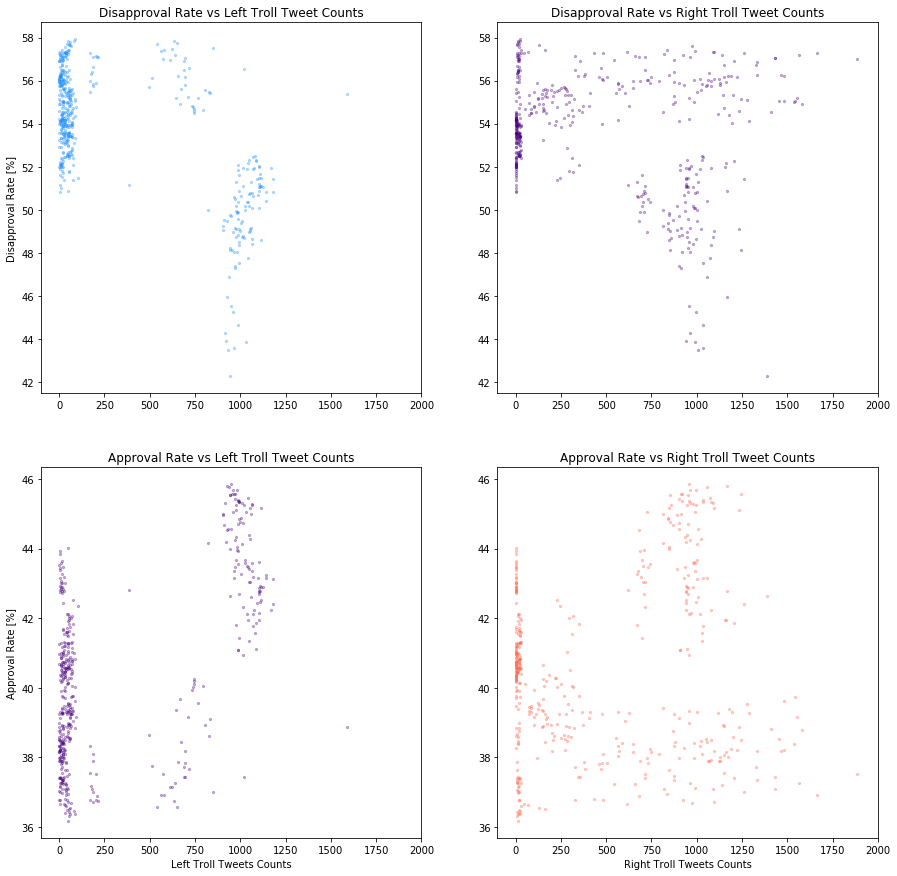

In [12]:
figTweetPolls = plt.figure(figsize=(15,15))

ax1 = figTweetPolls.add_subplot(2,2,1)
data_tweet_polls.plot.scatter(x='LeftTroll count', y='adjusted_disapprove', ax=ax1, color='dodgerblue',marker='.',alpha=0.3, legend=False)
ax1.set_title('Disapproval Rate vs Left Troll Tweet Counts')
ax1.set_xlabel('')#'Left Troll Tweets Counts')
ax1.set_ylabel('Disapproval Rate [%]')
ax1.set_xlim(-100,2000)

ax2 = figTweetPolls.add_subplot(2,2,2)
data_tweet_polls.plot.scatter(x='RightTroll count', y='adjusted_disapprove', ax=ax2, color='indigo',marker='.',alpha=0.3, legend=False)
ax2.set_title('Disapproval Rate vs Right Troll Tweet Counts')
ax2.set_xlabel('')#'Right Troll Tweets Counts')
ax2.set_ylabel('')#'Clinton Polls Rate [%]')
ax2.set_xlim(-100,2000)

ax3 = figTweetPolls.add_subplot(2,2,3)
data_tweet_polls.plot.scatter(x='LeftTroll count', y='adjusted_approve', ax=ax3, color='indigo',marker='.',alpha=0.3, legend=False)
ax3.set_title('Approval Rate vs Left Troll Tweet Counts')
ax3.set_xlabel('Left Troll Tweets Counts')
ax3.set_ylabel('Approval Rate [%]')
ax3.set_xlim(-100,2000)

ax4 = figTweetPolls.add_subplot(2,2,4)
data_tweet_polls.plot.scatter(x='RightTroll count', y='adjusted_approve', ax=ax4, color='tomato',marker='.',alpha=0.3, legend=False)
ax4.set_title('Approval Rate vs Right Troll Tweet Counts')
ax4.set_xlabel('Right Troll Tweets Counts')
ax4.set_ylabel('')#'Trump Polls Rate [%]')
ax4.set_xlim(-100,2000)

plt.show()

In [13]:
data_tweet_polls.corr('spearman')

,adjusted_approve,adjusted_disapprove,RightTroll count,LeftTroll count
adjusted_approve,1.000000,-0.985029,-0.115261,0.427039
adjusted_disapprove,-0.985029,1.000000,0.057874,-0.445731
RightTroll count,-0.115261,0.057874,1.000000,0.389265
LeftTroll count,0.427039,-0.445731,0.389265,1.000000


As visible in the above plot and the corresponding pearson coefficient, there are no clear correlation between number of troll tweets and the polls rate. <br>
However we cannot expect the troll tweet to change the polls drastically up to the percent changes. There are many more factors playing in the poll than just the troll tweets. In consequences, we will look at the polls variation over time and look whether it correltate with troll activity on twitter. To do so we compute the derivative of the polls rate with respect to time:  

### Variation of approval score

In [14]:
#get the derivative with respect to time for the Clinton and Trump Polls 
data_tweet_polls[['ddisapprove', 'dapprove']] = data_tweet_polls[['adjusted_disapprove','adjusted_approve']].diff()
data_tweet_polls['time_diff'] = data_tweet_polls.index.to_series().diff().dt.days
data_tweet_polls['ddisapprove/dt'] = data_tweet_polls['ddisapprove']/data_tweet_polls['time_diff']
data_tweet_polls['dapprove/dt'] = data_tweet_polls['dapprove']/data_tweet_polls['time_diff']
data_tweet_polls.head(2)

,adjusted_approve,adjusted_disapprove,RightTroll count,LeftTroll count,ddisapprove,dapprove,time_diff,ddisapprove/dt,dapprove/dt
2017-01-20,42.644602,42.271389,1387.0,941.0,NaN,NaN,NaN,NaN,NaN
2017-01-21,43.145552,43.590006,1036.0,964.0,1.318618,0.50095,1.0,1.318618,0.50095


We can now visualize how the polls variation changes with the troll tweets counts : 

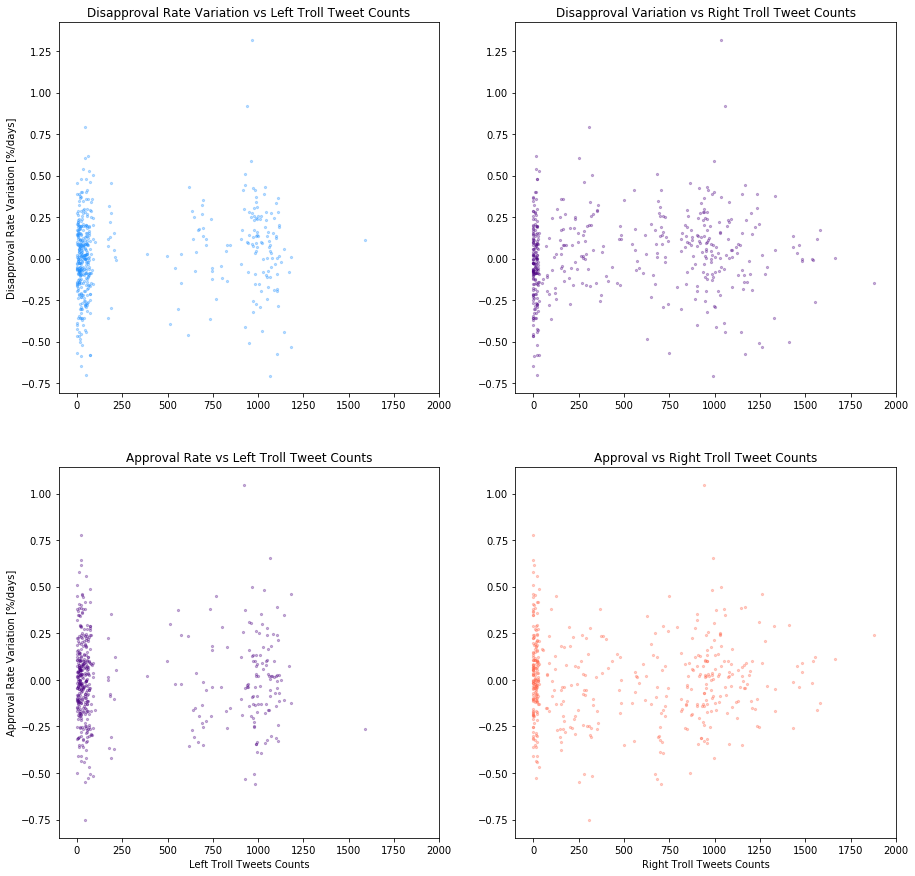

In [15]:
figTweetVarPolls = plt.figure(figsize=(15,15))

ax1 = figTweetVarPolls.add_subplot(2,2,1)
data_tweet_polls.plot.scatter(x='LeftTroll count', y='ddisapprove/dt', ax=ax1, color='dodgerblue',marker='.',alpha=0.3, legend=False)
ax1.set_title('Disapproval Rate Variation vs Left Troll Tweet Counts')
ax1.set_xlabel('')#'Left Troll Tweets Counts')
ax1.set_ylabel('Disapproval Rate Variation [%/days]')
ax1.set_xlim(-100,2000)

ax2 = figTweetVarPolls.add_subplot(2,2,2)
data_tweet_polls.plot.scatter(x='RightTroll count', y='ddisapprove/dt', ax=ax2, color='indigo',marker='.',alpha=0.3, legend=False)
ax2.set_title('Disapproval Variation vs Right Troll Tweet Counts')
ax2.set_xlabel('')#'Right Troll Tweets Counts')
ax2.set_ylabel('')#'Clinton Polls Rate [%]')
ax2.set_xlim(-100,2000)

ax3 = figTweetVarPolls.add_subplot(2,2,3)
data_tweet_polls.plot.scatter(x='LeftTroll count', y='dapprove/dt', ax=ax3, color='indigo',marker='.',alpha=0.3, legend=False)
ax3.set_title('Approval Rate vs Left Troll Tweet Counts')
ax3.set_xlabel('Left Troll Tweets Counts')
ax3.set_ylabel('Approval Rate Variation [%/days]')
ax3.set_xlim(-100,2000)

ax4 = figTweetVarPolls.add_subplot(2,2,4)
data_tweet_polls.plot.scatter(x='RightTroll count', y='dapprove/dt', ax=ax4, color='tomato',marker='.',alpha=0.3, legend=False)
ax4.set_title('Approval vs Right Troll Tweet Counts')
ax4.set_xlabel('Right Troll Tweets Counts')
ax4.set_ylabel('')#'Trump Polls Rate [%]')
ax4.set_xlim(-100,2000)

plt.show()

Here is another way of looking (qualitatively) at it : 

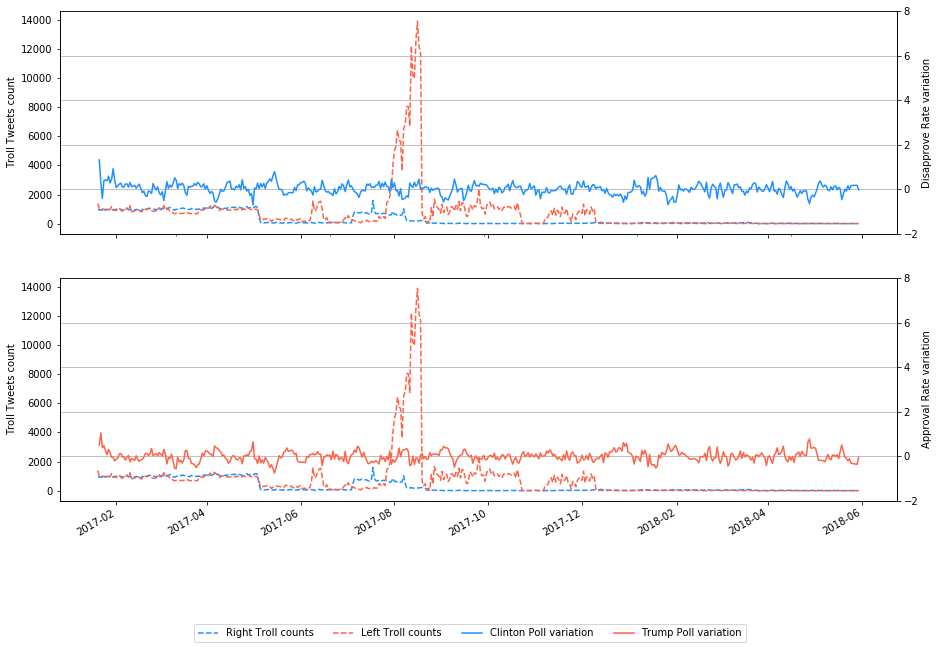

In [16]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax1_2 = ax1.twinx()
data_tweet_polls.loc[:,['LeftTroll count','RightTroll count']].plot(ax=ax1, color=['dodgerblue','tomato'], linestyle='--')
data_tweet_polls.loc[:,['ddisapprove/dt']].plot(ax=ax1_2, color='dodgerblue')
ax1_2.set_ylim(-2,8)
ax1_2.grid(True)
ax1.set_ylabel('Troll Tweets count')
ax1_2.set_ylabel('Disapprove Rate variation')

ax2 = fig.add_subplot(212)
ax2_2 = ax2.twinx()
data_tweet_polls.loc[:,['LeftTroll count','RightTroll count']].plot(ax=ax2, color=['dodgerblue','tomato'], linestyle='--')
data_tweet_polls.loc[:,['dapprove/dt']].plot(ax=ax2_2, color='tomato')
ax2_2.set_ylim(-2,8)
ax2_2.grid(True)
ax2.set_ylabel('Troll Tweets count')
ax2_2.set_ylabel('Approval Rate variation')

ax1.legend().remove()
ax1_2.legend().remove()
ax2.legend().remove()
ax2_2.legend().remove()

fig.legend((ax1.get_lines()[0],ax1.get_lines()[1],ax1_2.get_lines()[0],ax2_2.get_lines()[0]),\
           ('Right Troll counts','Left Troll counts','Clinton Poll variation','Trump Poll variation'),\
           loc = 'lower center', ncol=4 )

plt.show()

In [17]:
data_tweet_polls[['RightTroll count','LeftTroll count','ddisapprove/dt','dapprove/dt']].corr(method='spearman')

,RightTroll count,LeftTroll count,ddisapprove/dt,dapprove/dt
RightTroll count,1.000000,0.389265,0.131656,-0.045466
LeftTroll count,0.389265,1.000000,0.128798,-0.051435
ddisapprove/dt,0.131656,0.128798,1.000000,-0.769303
dapprove/dt,-0.045466,-0.051435,-0.769303,1.000000


### Number of users reached

Even here, it does not seems that the number of troll tweets correlate with the polls variations. We should look for other variables that may correlate with the polls: we'll start by looking at the number of person directly touched by the tweets (*i.e.* the number of followers). 

We get how many people (the maximum people) are reached everyday by right and left trolls respectively:

In [18]:
people=tweet_data[['publish_date', 'account_category','followers', 'author']]\
            .groupby(by=['publish_date', 'account_category', 'author']).max()\
            .unstack('account_category').fillna(0)\
            .groupby('publish_date').sum()
people.followers.head()

account_category,LeftTroll,RightTroll
publish_date,,
2014-10-18,6.0,0.0
2014-11-25,0.0,84.0
2014-11-26,0.0,84.0
2014-11-28,0.0,84.0
2014-12-01,0.0,98.0


In [19]:
p3 = figure(plot_width=850, plot_height=450, x_axis_type='datetime')
p3.title.text = 'Maximal People directly reached by the tweets'
p3.yaxis.axis_label = 'Tweet density'

source = ColumnDataSource(data=people.followers)
right=p3.line(x='publish_date', y='LeftTroll', line_width=2, alpha=1, legend='Left', color='dodgerblue', source=source)

source = ColumnDataSource(data=people.followers)
left=p3.line(x='publish_date', y='RightTroll', line_width=2, alpha=1, legend='Right', color='tomato', source=source)
p3.legend.location = 'top_left'
p3.legend.click_policy='hide'

hover_tool_R=tools.HoverTool(
    tooltips=[
        ('Date', '@publish_date{%F}'),
        ('People reached','@RightTroll')],
    formatters={
        'publish_date' : 'datetime', # use 'datetime' formatter for 'date' field
        'RightTroll' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    mode='vline',
    renderers=[right],
    attachment='above'
)

hover_tool_L=tools.HoverTool(
    tooltips=[
        ('Date', '@publish_date{%F}'),
        ('People reached','@LeftTroll')],
    formatters={
        'publish_date' : 'datetime', # use 'datetime' formatter for 'date' field
        'LeftTrollTroll' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    mode='vline',
    renderers=[left],
    attachment='above'
)

p3.tools.append(hover_tool_R)
p3.tools.append(hover_tool_L)

p4 = figure(plot_width=850, plot_height=450, x_axis_type='datetime')
p4.title.text = 'Tweeting activity according to Right and Left category'
p4.yaxis.axis_label = 'Tweet density'

categories=tweet_data.account_category.unique()
colorplot = ['tomato','dodgerblue']

for color, category in enumerate(categories):
    df_plot = pd.DataFrame(tweet_data[tweet_data.account_category==category].publish_date.value_counts().sort_index())
    source = ColumnDataSource(data=df_plot)
    p4.line(x='index', y='publish_date', source=source,\
            line_width=2, alpha=0.8, legend=category, color=colorplot[color])

p4.legend.location = 'top_left'
p4.legend.click_policy='hide'

hover_tool=tools.HoverTool(
    tooltips=[
        ('Date', '@index{%b %d, %Y}'),
        ('Number of tweets','@publish_date')],

    formatters={
        'index' : 'datetime', # use 'datetime' formatter for 'date' field
        'publish_date' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline'
)

p4.tools.append(hover_tool)

#output_notebook()
follower_plot = gridplot([[p3],[p4]])

In [20]:
#show(follower_plot)
output_file(plot_files+'NbUserReached_presidency.html')
save(follower_plot)

'/Users/Jean-BaptistePROST/Documents/EPFL/ADA-Proj-18/Plots/NbUserReached_presidency.html'

Plot can be seen [here](Plots/NbUserReached_presidency.html)

In [21]:
data_follower_polls = data_poll_avg[['adjusted_disapprove','adjusted_approve']].merge(people.followers, left_index=True, right_index=True)
data_follower_polls.head(2)

,adjusted_disapprove,adjusted_approve,LeftTroll,RightTroll
2017-01-20,42.271389,42.644602,167628.0,371765.0
2017-01-21,43.590006,43.145552,149770.0,308236.0


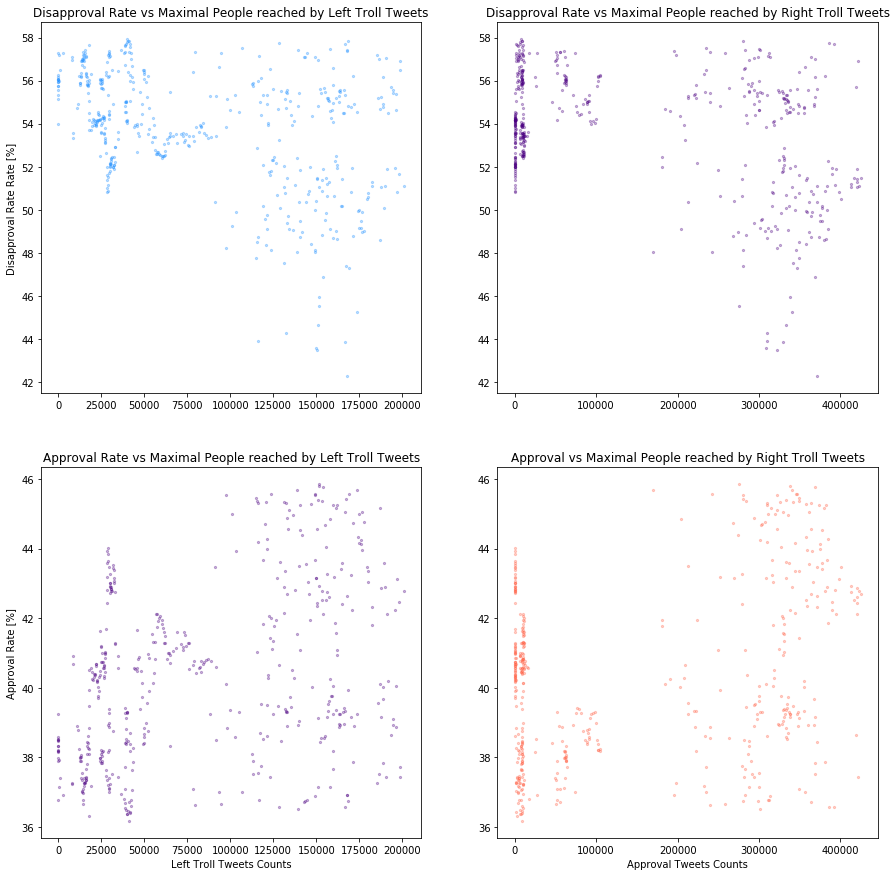

In [22]:
figFollowerPolls = plt.figure(figsize=(15,15))

ax1 = figFollowerPolls.add_subplot(2,2,1)
data_follower_polls.plot.scatter(x='LeftTroll', y='adjusted_disapprove', ax=ax1, color='dodgerblue',marker='.',alpha=0.3, legend=False)
ax1.set_title('Disapproval Rate vs Maximal People reached by Left Troll Tweets')
ax1.set_xlabel('')#'Left Troll Tweets Counts')
ax1.set_ylabel('Disapproval Rate Rate [%]')
#ax1.set_xlim(-100,2000)

ax2 = figFollowerPolls.add_subplot(2,2,2)
data_follower_polls.plot.scatter(x='RightTroll', y='adjusted_disapprove', ax=ax2, color='indigo',marker='.',alpha=0.3, legend=False)
ax2.set_title('Disapproval Rate vs Maximal People reached by Right Troll Tweets')
ax2.set_xlabel('')#'Right Troll Tweets Counts')
ax2.set_ylabel('')#'Clinton Polls Rate [%]')
#ax2.set_xlim(-100,2000)

ax3 = figFollowerPolls.add_subplot(2,2,3)
data_follower_polls.plot.scatter(x='LeftTroll', y='adjusted_approve', ax=ax3, color='indigo',marker='.',alpha=0.3, legend=False)
ax3.set_title('Approval Rate vs Maximal People reached by Left Troll Tweets')
ax3.set_xlabel('Left Troll Tweets Counts')
ax3.set_ylabel('Approval Rate [%]')
#ax3.set_xlim(-100,2000)

ax4 = figFollowerPolls.add_subplot(2,2,4)
data_follower_polls.plot.scatter(x='RightTroll', y='adjusted_approve', ax=ax4, color='tomato',marker='.',alpha=0.3, legend=False)
ax4.set_title('Approval vs Maximal People reached by Right Troll Tweets')
ax4.set_xlabel('Approval Tweets Counts')
ax4.set_ylabel('')#'Trump Polls Rate [%]')
#ax4.set_xlim(-100,2000)

plt.show()

In [23]:
data_follower_polls.corr(method='spearman')

,adjusted_disapprove,adjusted_approve,LeftTroll,RightTroll
adjusted_disapprove,1.000000,-0.985029,-0.387015,-0.240744
adjusted_approve,-0.985029,1.000000,0.380687,0.196713
LeftTroll,-0.387015,0.380687,1.000000,0.768046
RightTroll,-0.240744,0.196713,0.768046,1.000000


In [24]:
data_follower_dpolls = data_follower_polls.merge(data_tweet_polls[['ddisapprove/dt','dapprove/dt']], right_index=True, left_index=True)
data_follower_dpolls.head()

,adjusted_disapprove,adjusted_approve,LeftTroll,RightTroll,ddisapprove/dt,dapprove/dt
2017-01-20,42.271389,42.644602,167628.0,371765.0,NaN,NaN
2017-01-21,43.590006,43.145552,149770.0,308236.0,1.318618,0.500950
2017-01-22,43.888456,44.193660,116343.0,309386.0,0.298449,1.048107
2017-01-23,43.478335,44.570419,150331.0,321876.0,-0.410120,0.376760
2017-01-24,43.865453,45.051454,166711.0,329753.0,0.387118,0.481034


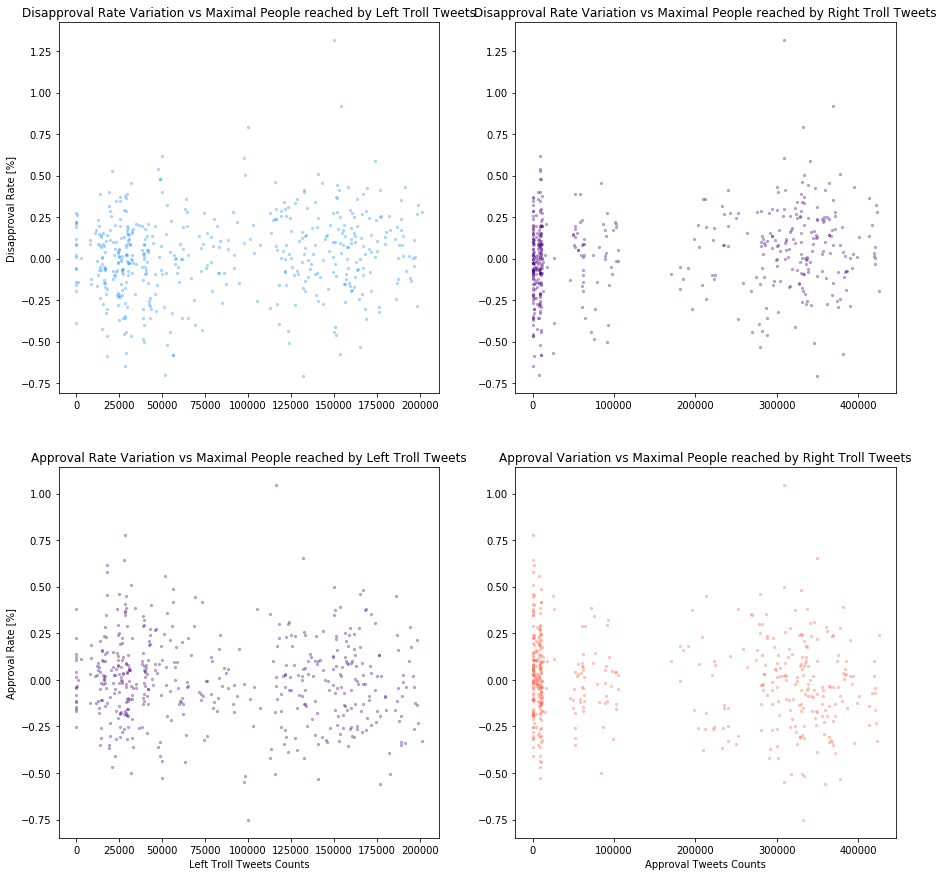

In [25]:
figFollower_dPolls = plt.figure(figsize=(15,15))

ax1 = figFollower_dPolls.add_subplot(2,2,1)
data_follower_dpolls.plot.scatter(x='LeftTroll', y='ddisapprove/dt', ax=ax1, color='dodgerblue',marker='.',alpha=0.3, legend=False)
ax1.set_title('Disapproval Rate Variation vs Maximal People reached by Left Troll Tweets')
ax1.set_xlabel('')#'Left Troll Tweets Counts')
ax1.set_ylabel('Disapproval Rate [%]')
#ax1.set_xlim(-100,2000)

ax2 = figFollower_dPolls.add_subplot(2,2,2)
data_follower_dpolls.plot.scatter(x='RightTroll', y='ddisapprove/dt', ax=ax2, color='indigo',marker='.',alpha=0.3, legend=False)
ax2.set_title('Disapproval Rate Variation vs Maximal People reached by Right Troll Tweets')
ax2.set_xlabel('')#'Right Troll Tweets Counts')
ax2.set_ylabel('')#'Clinton Polls Rate [%]')
#ax2.set_xlim(-100,2000)

ax3 = figFollower_dPolls.add_subplot(2,2,3)
data_follower_dpolls.plot.scatter(x='LeftTroll', y='dapprove/dt', ax=ax3, color='indigo',marker='.',alpha=0.3, legend=False)
ax3.set_title('Approval Rate Variation vs Maximal People reached by Left Troll Tweets')
ax3.set_xlabel('Left Troll Tweets Counts')
ax3.set_ylabel('Approval Rate [%]')
#ax3.set_xlim(-100,2000)

ax4 = figFollower_dPolls.add_subplot(2,2,4)
data_follower_dpolls.plot.scatter(x='RightTroll', y='dapprove/dt', ax=ax4, color='tomato',marker='.',alpha=0.3, legend=False)
ax4.set_title('Approval Variation vs Maximal People reached by Right Troll Tweets')
ax4.set_xlabel('Approval Tweets Counts')
ax4.set_ylabel('')#'Trump Polls Rate [%]')
#ax4.set_xlim(-100,2000)

plt.show()

In [26]:
data_follower_dpolls.corr(method='spearman')

,adjusted_disapprove,adjusted_approve,LeftTroll,RightTroll,ddisapprove/dt,dapprove/dt
adjusted_disapprove,1.000000,-0.985029,-0.387015,-0.240744,-0.088255,-0.009704
adjusted_approve,-0.985029,1.000000,0.380687,0.196713,0.085275,0.015201
LeftTroll,-0.387015,0.380687,1.000000,0.768046,0.125892,-0.082131
RightTroll,-0.240744,0.196713,0.768046,1.000000,0.192738,-0.139781
ddisapprove/dt,-0.088255,0.085275,0.125892,0.192738,1.000000,-0.769303
dapprove/dt,-0.009704,0.015201,-0.082131,-0.139781,-0.769303,1.000000


## Topic

We now examine the potential correlation between the polls and the topics. The topics were previously defined in the `WebScrap.ipynb`. The number of tweet per day for each topic is compared with the approval score for each candidate.

In [27]:
def load_topic_df(filename=pickle_files +'topic_df.plk'):
    """Load the pickle generated in the WebScrap.ipynb
    Contains: the tweet content, the publish_data, the topics"""
    with open(filename, 'rb') as df_top:
            df_topic=pickle.load(df_top) 
        
    print("Df topic loaded <---")
    
    return df_topic        

In [28]:
#loading data
df_topic=load_topic_df()
df_topic.columns

Df topic loaded <---


Index(['publish_date', 'content', 'account_category', 'Clean_tweet',
       'hashtags', 'Music', 'Movies', 'Trump', 'Hillary', 'Religion',
       'Conservative', 'Fear', 'BlackLivesMatter', 'Voter', 'MeToo',
       'Terrorism', 'Hacking', 'Sanders', 'Obama', 'FakeNews', 'Gouvernment',
       'Healthcare', 'Gun', 'Sport', 'Scandal', 'Election', 'Charlottesville',
       'Economy', 'Categorical'],
      dtype='object')

In [29]:
#selecting relevant columns
df_topic=df_topic.drop(columns={'content', 'Clean_tweet', 'hashtags','Categorical','Charlottesville', 'Election' })
print('\nThe {} topics are:\n    {}'.format(len(df_topic.columns[2:]), '\n    '.join([topic for topic in df_topic.columns[2:].tolist()])))


The 21 topics are:
    Music
    Movies
    Trump
    Hillary
    Religion
    Conservative
    Fear
    BlackLivesMatter
    Voter
    MeToo
    Terrorism
    Hacking
    Sanders
    Obama
    FakeNews
    Gouvernment
    Healthcare
    Gun
    Sport
    Scandal
    Economy


In [30]:
df_poll_topic= data_poll_avg.drop(columns={'samplesize','weight','influence', 'approve','disapprove','poll_id'})
#Get the count of tweet per day for each category
df_topic=df_topic.groupby(by=['account_category','publish_date']).sum().unstack("account_category").fillna(0)

In [31]:
df_poll_topic.head()

,adjusted_approve,adjusted_disapprove
startdate,,
2017-01-20,42.644602,42.271389
2017-01-21,43.145552,43.590006
2017-01-22,44.193660,43.888456
2017-01-23,44.570419,43.478335
2017-01-24,45.051454,43.865453


Merging the polls data and the topic tweet count per day.

In [32]:
df_scatter=df_poll_topic.merge(df_topic, how='inner', right_index=True, left_index=True)
topic_selected=df_scatter.columns.tolist()[2:]
#Renaming columns
df_scatter.columns= df_scatter.columns[:2].tolist()+ [t[0]+'_'+t[1] for t in topic_selected]

/Users/Jean-BaptistePROST/miniconda3/envs/ada/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [33]:
df_scatter.head()

,adjusted_approve,adjusted_disapprove,Music_LeftTroll,Music_RightTroll,Movies_LeftTroll,Movies_RightTroll,Trump_LeftTroll,Trump_RightTroll,Hillary_LeftTroll,Hillary_RightTroll,...,Healthcare_LeftTroll,Healthcare_RightTroll,Gun_LeftTroll,Gun_RightTroll,Sport_LeftTroll,Sport_RightTroll,Scandal_LeftTroll,Scandal_RightTroll,Economy_LeftTroll,Economy_RightTroll
2017-01-20,42.644602,42.271389,143.0,13.0,26.0,22.0,123.0,504.0,5.0,36.0,...,11.0,20.0,5.0,11.0,6.0,12.0,8.0,9.0,7.0,22.0
2017-01-21,43.145552,43.590006,114.0,14.0,33.0,20.0,117.0,356.0,4.0,35.0,...,19.0,12.0,3.0,15.0,11.0,13.0,4.0,5.0,6.0,15.0
2017-01-22,44.193660,43.888456,111.0,16.0,25.0,12.0,103.0,256.0,6.0,27.0,...,9.0,6.0,2.0,3.0,11.0,25.0,4.0,8.0,7.0,19.0
2017-01-23,44.570419,43.478335,134.0,13.0,42.0,17.0,88.0,308.0,1.0,26.0,...,9.0,15.0,3.0,8.0,15.0,10.0,10.0,4.0,9.0,35.0
2017-01-24,45.051454,43.865453,137.0,14.0,59.0,22.0,91.0,320.0,8.0,19.0,...,8.0,13.0,4.0,13.0,12.0,15.0,10.0,13.0,11.0,34.0


**Plotting and Correlation computing**

The Spearman correlation coefficient is computed.

In [34]:
p_dl = figure(plot_width=800, plot_height=600, y_range=(0,1000))
p_dr=figure(plot_width=800, plot_height=600, y_range=(0,1000))

p_ar=figure(plot_width=800, plot_height=600, y_range=(0,1000))
p_al = figure(plot_width=800, plot_height=600, y_range=(0,1000))


colors= ['darkolivegreen', 'darkmagenta','tomato', 'dodgerblue', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki', 'darkolivegreen']

source=ColumnDataSource(data=df_scatter)

df_corr=pd.DataFrame()

for color, topic in enumerate(df_topic.columns.levels[0]):
    
    #correlation
    df_corr.loc[topic,'Dl']=df_scatter.loc[:, [topic+'_LeftTroll', 'adjusted_disapprove']].corr(method='spearman').values.flatten()[1]
    df_corr.loc[topic,'Al']=df_scatter.loc[:, [topic+'_LeftTroll', 'adjusted_approve']].corr(method='spearman').values.flatten()[1]
    df_corr.loc[topic,'Ar']=df_scatter.loc[:, [topic+'_RightTroll', 'adjusted_approve']].corr(method='spearman').values.flatten()[1]
    df_corr.loc[topic,'Dr']=df_scatter.loc[:, [topic+'_RightTroll', 'adjusted_disapprove']].corr(method='spearman').values.flatten()[1]
    
    #plotting
    p_dl.scatter(x='adjusted_disapprove', y=topic+'_LeftTroll', source=source, legend=topic, color=colors[color])
    p_dl.yaxis.axis_label = 'LeftTroll'
    p_dl.xaxis.axis_label='Disapproval'
    
   
    p_dr.scatter(x='adjusted_disapprove', y=topic+'_RightTroll', source=source, legend=topic, color=colors[color])
    p_dr.yaxis.axis_label = 'RightTroll'
    p_dr.xaxis.axis_label='Disapproval'
    
    p_al.scatter(x='adjusted_approve', y=topic+'_LeftTroll', source=source, legend=topic, color=colors[color])
    p_al.yaxis.axis_label = 'LeftTroll'
    p_al.xaxis.axis_label='Approval'
    
    
    p_ar.scatter(x='adjusted_approve', y=topic+'_RightTroll', source=source, legend=topic, color=colors[color])
    p_ar.yaxis.axis_label = 'RightTroll'
    p_ar.xaxis.axis_label='Approval'
    
    p_dl.legend.click_policy='hide'
    p_dr.legend.click_policy='hide'
    p_al.legend.click_policy='hide'
    p_ar.legend.click_policy='hide'
    

p_ar.legend.location = 'top_left'
p_ar.legend.orientation = "vertical"
p_ar.legend.label_text_font_size="12pt"

p_dl.legend.location = 'top_left'
p_dl.legend.orientation = "vertical"
p_dl.legend.label_text_font_size="12pt"

p_dr.legend.location = 'top_left'
p_dr.legend.orientation = "vertical"
p_dr.legend.label_text_font_size="12pt"


p_dl.legend.location = 'top_left'
p_dl.legend.orientation = "vertical"
p_dl.legend.label_text_font_size="12pt"

grid=column([p_dl, p_dr, p_ar, p_al])
#output_notebook()

In [35]:
output_file(plot_files+'Approval_Topic.html')
save(grid)

'/Users/Jean-BaptistePROST/Documents/EPFL/ADA-Proj-18/Plots/Approval_Topic.html'

The plot can be find [here](Plots/Approval_Topic.html). 

In [36]:
#show(grid)

In [37]:
df_corr.index.name='topic'
df_corr.to_csv(csv_files+'CorrelationApporval_topic.csv')
df_corr

,Dl,Al,Ar,Dr
topic,,,,
Music,-0.437621,0.408862,0.122856,-0.172091
Movies,-0.397681,0.382933,0.062267,-0.116500
Trump,-0.477395,0.472438,-0.121224,0.067322
Hillary,-0.447581,0.437146,-0.220173,0.156867
Religion,-0.454525,0.434791,0.145373,-0.188752
Conservative,-0.512770,0.492765,0.125619,-0.174539
Fear,-0.471667,0.452602,-0.021724,-0.029958
BlackLivesMatter,-0.433862,0.411354,-0.139076,0.081629
Voter,-0.399305,0.389648,-0.038794,-0.013178


Saving to csv.

In [38]:
df_scatter.index.name='date'
df_scatter.to_csv(csv_files+'Scatter_Polls_Topics_Pesidency.csv')